In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.constants import c
import importlib

import tools
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [83]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [84]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi

In [85]:
icApi = lumapi.INTERCONNECT()

In [86]:
icApi.switchtolayout()
icApi.deleteall()

In [3]:
#units
nm = 1e-9
um = 1e-6

In [4]:
#waveguide data
ng = 4.19088 #pdk
neff = 2.44553 #pdk
#bandwidth
wavelength_start = 1530*nm
wavelength_stop = 1565*nm
centralWl = (wavelength_start + wavelength_stop)/2
filenames = ['S_parameters_BB_DC_14um_TE.dat','S_parameters_BB_DC_8um_TE.dat','S_parameters_BB_DC_3um_TE.dat']

In [5]:
importlib.reload(tools)
df, outputs = tools.getKappa(icApi,10000, c/(1530*nm), c/(1565*nm), 17*um, 19*um,1*um)

NameError: name 'icApi' is not defined

In [90]:
df['Coupling Length (um)'][0]

np.float64(17.0)

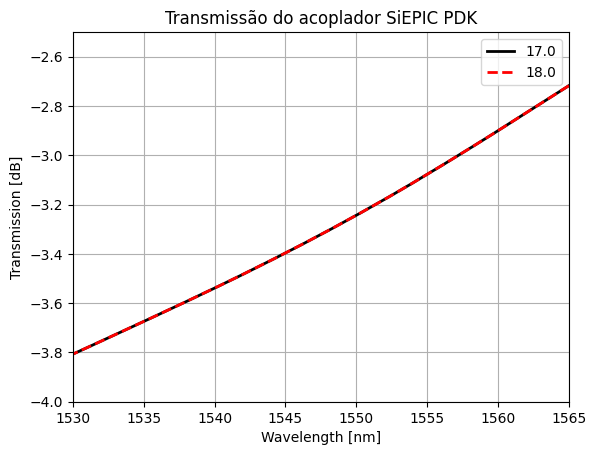

In [91]:
lines = ['-','--']
colors = ['black', 'red']
for i in range(len(outputs)):
    plt.plot(outputs[i]['wavelength']/nm, outputs[i]["'TE' gain (dB)"],label=f'{df['Coupling Length (um)'][i]}',linestyle=lines[i], linewidth=2,color=colors[i])

plt.xlim(1530, 1565)
plt.ylim(-4,-2.5)
plt.grid()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.title('Transmissão do acoplador SiEPIC PDK')
plt.legend()
plt.savefig('Transmissão do acoplador SiEPIC PDK.png')

## Monte Carlo

In [92]:
## Monte Carlo
def MonteCarlo(device):
    icApi.deletesweep("MC_script")
    ##add a sweep
    trials = 10
    icApi.addsweep(2)
    MC_name = 'MC_script'
    icApi.setsweep('Monte Carlo analysis', 'name', MC_name)
    icApi.setsweep(MC_name, 'number of trials', trials)
    icApi.setsweep(MC_name, 'enable seed', 1)
    icApi.setsweep(MC_name, 'seed', 1)
    icApi.setsweep(MC_name, 'Variation', 'Both')
    #setup
    icApi.switchtolayout()
    icApi.setsweep(MC_name, 'type', 'Parameters')
    icApi.refresh()
    scopes = ['3 st']  #, '2 st A', '2 st B', '1 st A', '1 st B', '1 st C', '1 st D']
    icApi.groupscope('3 st')
    components = ['wg1']  #, 'wg2', 'wg3', 'wg4']
    for i, scope in enumerate(scopes):
        icApi.refresh()
        icApi.groupscope(scope)
        for j, comp in enumerate(components):
            #width
            param = icApi.struct()
            param['Name'] = f'{scopes[i]}_wg{j + 1}_width'
            param['Parameter'] = f'::Root Element::3 st::{comp}::wg_width'
            param['Value'] = icApi.getnamed(f'{comp}', 'wg_width')
            dis = icApi.struct()
            dis['type'] = 'gaussian'
            dis['variation'] = 5e-9
            param['Distribution'] = dis
            icApi.addsweepparameter(MC_name, param)

    #results parameters

    for i in range(len(outputsOna)):
        Tr = icApi.struct()
        Tr['Name'] = "Transmission"
        Tr['Result'] = f"::Root Element::ona1::input {i + 1}/mode 1/gain"
        Tr['Estimation'] = True
        icApi.addsweepresult(MC_name, Tr)

    icApi.runsweep(MC_name)
    res = icApi.getsweepresult(MC_name, 'Transmission')
    res1 = icApi.getsweepresult(MC_name, 'Transmission1')
    res2 = icApi.getsweepresult(MC_name, 'Transmission2')
    res3 = icApi.getsweepresult(MC_name, 'Transmission3')
    res4 = icApi.getsweepresult(MC_name, 'Transmission4')
    res5 = icApi.getsweepresult(MC_name, 'Transmission5')
    res6 = icApi.getsweepresult(MC_name, 'Transmission6')
    res7 = icApi.getsweepresult(MC_name, 'Transmission7')
    wl = res['wavelength'].flatten()
    
    plt.figure()
    for i in range(trials):
        gain = res['mode 1 gain (dB)'][:, i]
        plt.plot(wl / nm, res1['mode 1 gain (dB)'][:, i], linewidth=2, color='black')
        plt.plot(wl / nm, res2['mode 1 gain (dB)'][:, i], linewidth=2, color='red')
        plt.plot(wl / nm, res3['mode 1 gain (dB)'][:, i], linewidth=2, color='blue')
        plt.plot(wl / nm, res4['mode 1 gain (dB)'][:, i], linewidth=2, color='green')
        plt.plot(wl / nm, res5['mode 1 gain (dB)'][:, i], linewidth=2, color='orange')
        plt.plot(wl / nm, res6['mode 1 gain (dB)'][:, i], linewidth=2, color='purple')
        plt.plot(wl / nm, res7['mode 1 gain (dB)'][:, i], linewidth=2, color='brown')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transmission (dB)')
    plt.title(f'Monte Carlo results {device}')
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(1530, 1565)
    plt.ylim(-25, 1)
    plt.savefig(f'Monte Carlo results {device}.png', dpi=300)
    plt.show()
    return _

In [93]:
importlib.reload(tools)
def calculateDelayLengths(L, FSR1):
    #L = 40*um
    #FSR1 =1.6*nm
    
    deltaLFS = centralWl/neff #eq (3)
    ### DeltaL base ####
    deltaLbase = (centralWl)**2 / (2*FSR1*ng)
    
    deltaLbase2 = deltaLbase/2
    
    deltaLbase3 = deltaLbase/4
    
    ##### SHIFTS #####
    deltaLshifts2st = [0, 0.75*deltaLFS] # A B 
    deltaLshifts1st = [0, 0.25*deltaLFS,0.125*deltaLFS,0.375*deltaLFS] #A B C D
    
    #### delta L por estagio ####
    dl2stA = deltaLbase2 + deltaLshifts2st[0]
    dl2stB = deltaLbase2 + deltaLshifts2st[1]
    dl1stA = deltaLbase3 + deltaLshifts1st[0]
    dl1stB = deltaLbase3 + deltaLshifts1st[1]
    dl1stC = deltaLbase3 + deltaLshifts1st[2]
    dl1stD = deltaLbase3 + deltaLshifts1st[3]
    #### names #####
    names = ['3 st', '2 st A', '2 st B', '1 st A', '1 st B', '1 st C', '1 st D']
    
    
    deltaL = tools.getDeltaL(FSR1, centralWl, ng)
    
    Lpi = tools.getLpi(centralWl, neff)
    #### delay lengths ####
    
    delayLengths = L + np.array([deltaLbase,2*deltaLbase,-2*deltaLbase +Lpi,-2*deltaLbase])
    
    delayLengths2ndA = L + np.array([dl2stA,2*dl2stA,(-2*dl2stA) +Lpi,-2*dl2stA])
    delayLengths2ndB = L + np.array([dl2stB,2*dl2stB,(-2*dl2stB) +Lpi,-2*dl2stB])
    
    delayLengths1stA = L + np.array([dl1stA,2*dl1stA,(-2*dl1stA) +Lpi,-2*dl1stA])
    delayLengths1stB = L + np.array([dl1stB,2*dl1stB,(-2*dl1stB) +Lpi,-2*dl1stB])
    delayLengths1stC = L + np.array([dl1stC,2*dl1stC,(-2*dl1stC) +Lpi,-2*dl1stC])
    delayLengths1stD = L + np.array([dl1stD,2*dl1stD,(-2*dl1stD) +Lpi,-2*dl1stD])
    
    delayLengths_values = [delayLengths,delayLengths2ndA,delayLengths2ndB, delayLengths1stA, delayLengths1stB, delayLengths1stC, delayLengths1stD]
    
    LC = np.array([18.71, 6.3, 6.3, 18.71,11.42])*um #0.5, 0.13, 0.12, 0.5, 0.25
    LC3rd = np.array([17.8, 10, 10, 3.6])*um #0.5 , 0.2, 0.2, 0.04
    LC2nd = np.array([18, 9.75, 6])*um #new = 0.5, 0.25, 0.08; old:0.5 , 0.29, 0.08
    LC1st = np.array([18.89,18.89])*um
    
    return delayLengths_values, names, LC, LC3rd, LC2nd, LC1st


In [94]:
L = 40*um
FSR = 1.6*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)

In [95]:
icApi.switchtolayout()

In [96]:
delayLengths_values[1]/um

array([ 129.28450923,  218.56901847, -138.25262489, -138.56901847])

In [97]:
importlib.reload(tools)
k = [0.5, 0.25,0.08]
#tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[0],k,LC,filenames, names[0], 3,3)

## 200GHz (IDEAL)

In [98]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,8,1000,c/wavelength_start, c/wavelength_stop)
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC,filenames, names[i], 3,1)

## Positioning devices

In [99]:
icApi.refresh()
#positioning compounds
def position():
    icApi.setposition('3 st', 700, 100)
    icApi.setposition('2 st A', 900, -10)
    icApi.setposition('2 st B', 900, 200)
    icApi.setposition('1 st A', 1200, -60)
    icApi.setposition('1 st B', 1200, 40)
    icApi.setposition('1 st C', 1200, 150)
    icApi.setposition('1 st D', 1200, 250)
    return _
position()

array([ 129.28450923,  218.56901847, -138.25262489, -138.56901847])

## Connections

In [100]:
def connect():    
    icApi.connect('3 st', 'port 2', 'ona1', 'output')
    
    icApi.connect('3 st', 'port 3', '2 st A', 'port 2')
    icApi.connect('3 st', 'port 4', '2 st B', 'port 1')
    
    icApi.connect('2 st A', 'port 3', '1 st A', 'port 2')
    icApi.connect('2 st A', 'port 4', '1 st B', 'port 1')
    
    icApi.connect('2 st B', 'port 3', '1 st C', 'port 2')
    icApi.connect('2 st B', 'port 4', '1 st D', 'port 1')
    
    #outputs to ona
    icApi.connect('1 st A', 'port 3', 'ona1', 'input 1')
    icApi.connect('1 st A', 'port 4', 'ona1', 'input 2')
    icApi.connect('1 st B', 'port 3', 'ona1', 'input 3')
    icApi.connect('1 st B', 'port 4', 'ona1', 'input 4')
    icApi.connect('1 st C', 'port 3', 'ona1', 'input 5')
    icApi.connect('1 st C', 'port 4', 'ona1', 'input 6')
    icApi.connect('1 st D', 'port 3', 'ona1', 'input 7')
    icApi.connect('1 st D', 'port 4', 'ona1', 'input 8')
    return _
connect()

array([ 129.28450923,  218.56901847, -138.25262489, -138.56901847])

In [101]:
icApi.save('200GHz_circuit')
icApi.run()

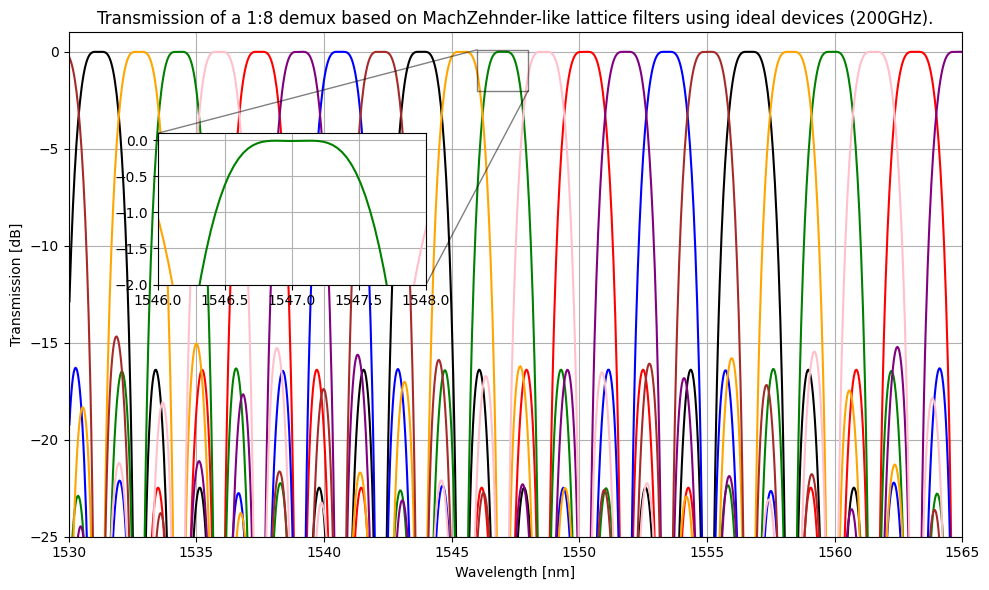

In [102]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])

#plt.vlines(1546.15, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--', label='canal 24')
#plt.vlines(1546.95, ymin=-60, ymax=1, color='black', linewidth=1, linestyles='--', label='canal 26')


zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    zoom.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1546, 1548, -2, 0.1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)

#plt.text(1549.2, -2, '1.6nm', fontsize=8.5)
#plt.hlines(-3, xmin=1530, xmax=1565, color='black', linewidth=1, linestyles='-.', label='-3dB')
#plt.legend()
plt.grid(True)
plt.title('Transmission of a 1:8 demux based on MachZehnder-like lattice filters using ideal devices (200GHz).')
plt.tight_layout()
plt.savefig('TransmissionIdeal200GHz.png', dpi=300)

## 100GHz (IDEAL)

In [54]:
L = 40*um
FSR = 0.8*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)

In [55]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,8,1000,c/wavelength_start, c/wavelength_stop)
k = [0.5, 0.25,0.08]
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC,filenames, names[i], 3,1)

In [56]:
position()
connect()
icApi.save('100GHz_circuit')

In [57]:
icApi.run()

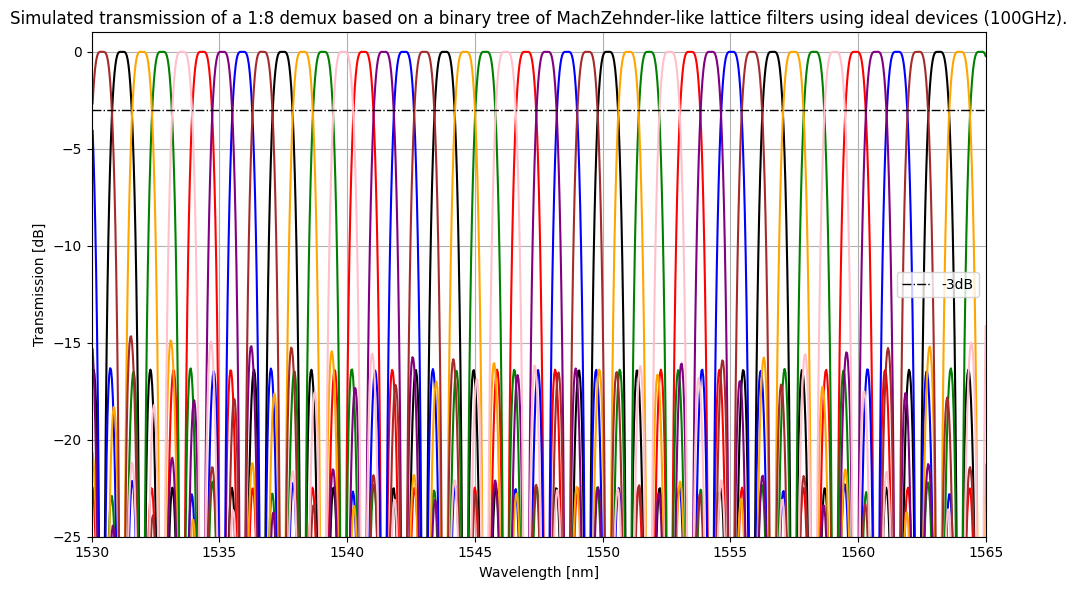

In [58]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    plt.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])

'''plt.vlines(1546.15, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--', label='canal 24')
plt.vlines(1546.95, ymin=-60, ymax=1, color='black', linewidth=1, linestyles='--', label='canal 26')
'''
#plt.vlines(1549.1, ymin=-60, ymax=1, color='black', linewidth=1, linestyles='--')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)
#plt.legend()
'''k = 0
for i in range(8):
    plt.text(1531.3+k, -1,rf'$\lambda${i+1}')
    k+= 1.6'''
#plt.text(1549.2, -2, '1.6nm', fontsize=8.5)
plt.hlines(-3, xmin=1530, xmax=1565, color='black', linewidth=1, linestyles='-.', label='-3dB')
plt.legend()
plt.grid(True)
plt.title('Simulated transmission of a 1:8 demux based on a binary tree of MachZehnder-like lattice filters using ideal devices (100GHz).')
plt.tight_layout()
plt.savefig('TransmissionIdeal100GHz.png', dpi=300)

## 50GHZ (IDEAL)

In [59]:
L = 40*um
FSR = 0.4*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)

In [60]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,8,1000,c/wavelength_start, c/wavelength_stop)
k = [0.5, 0.25,0.08]
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC,filenames, names[i], 3,1)

In [61]:
position()
connect()
icApi.save('100GHz_circuit')

In [62]:
icApi.run()

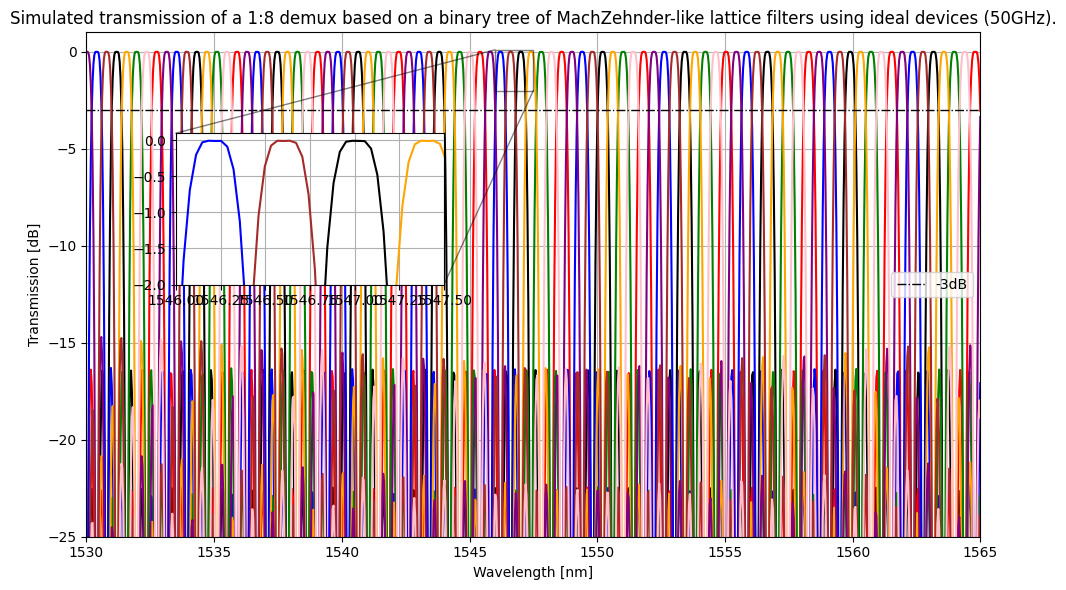

In [63]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])


'''plt.vlines(1546.15, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--', label='canal 24')
plt.vlines(1546.95, ymin=-60, ymax=1, color='black', linewidth=1, linestyles='--', label='canal 26')
'''

zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    zoom.plot(data['wavelength']/nm, data["TE gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1546, 1547.5, -2, 0.1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)
#plt.legend()
#plt.text(1549.2, -2, '1.6nm', fontsize=8.5)
plt.hlines(-3, xmin=1530, xmax=1565, color='black', linewidth=1, linestyles='-.', label='-3dB')
plt.legend()
plt.grid(True)
plt.title('Simulated transmission of a 1:8 demux based on a binary tree of MachZehnder-like lattice filters using ideal devices (50GHz).')
plt.tight_layout()
plt.savefig('TransmissionIdeal50GHz.png', dpi=300)

## 200GHz (PDK)

In [26]:
L = 40*um
FSR = 1.6*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)

In [27]:
delayLengths_values[0]/um

array([ 218.56901847,  397.13803694, -316.82164336, -317.13803694])

In [28]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,8,1000,c/wavelength_start, c/wavelength_stop)
k = [0.5, 0.25,0.08]
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC2nd,filenames, names[i], 3,2)

In [29]:
position()
connect()
icApi.save('200GHz_circuit_PDK')

In [30]:
icApi.run()

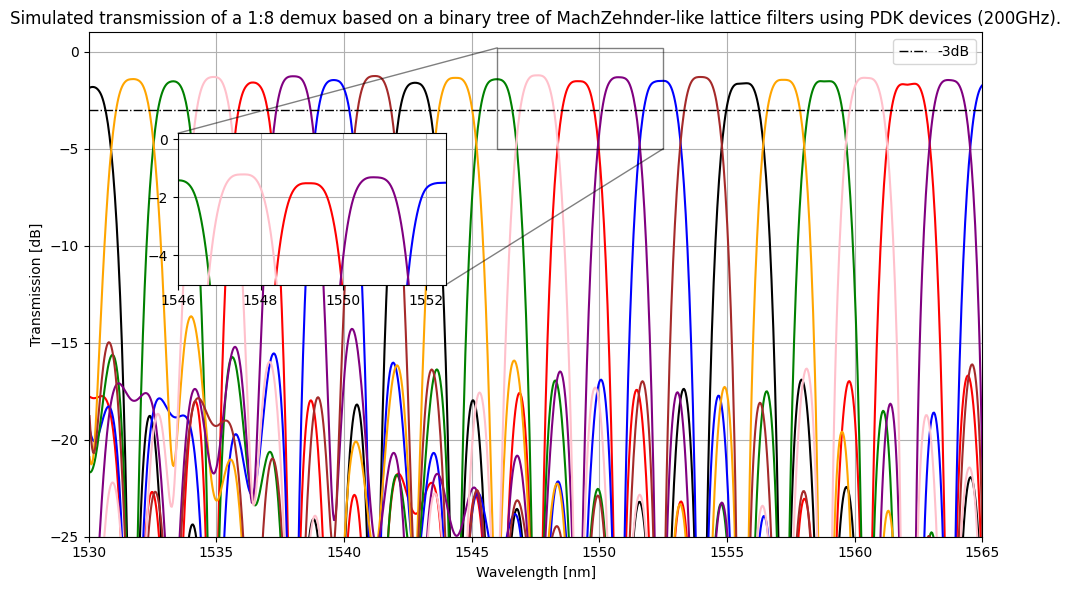

In [31]:
outputsOnaPDK200 = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOnaPDK200):
    dataPDK = icApi.getresult('ona1', path)
    ax.plot(dataPDK['wavelength']/nm, dataPDK["'TE' gain (dB)"], color=colors[i])


'''plt.vlines(1546.15, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--', label='canal 24')
plt.vlines(1546.95, ymin=-60, ymax=1, color='black', linewidth=1, linestyles='--', label='canal 26')
'''

zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOnaPDK200):
    dataPDK = icApi.getresult('ona1', path)
    zoom.plot(dataPDK['wavelength']/nm, dataPDK["'TE' gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1546, 1552.5, -5, 0.2
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)
#plt.legend()
#plt.text(1549.2, -2, '1.6nm', fontsize=8.5)
plt.hlines(-3, xmin=1530, xmax=1565, color='black', linewidth=1, linestyles='-.', label='-3dB')
plt.legend()
plt.grid(True)
plt.title('Simulated transmission of a 1:8 demux based on a binary tree of MachZehnder-like lattice filters using PDK devices (200GHz).')
plt.tight_layout()
plt.savefig('TransmissionPDK200GHz.png', dpi=300)

## Monte Carlo PDK

In [32]:
icApi.switchtolayout()
icApi.deleteall()

In [33]:
tools.placeOna(icApi,'ona1',1000,-200,2,1000,c/wavelength_start, c/wavelength_stop)
for i in range(1):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC2nd,filenames, names[i], 3,2)

In [34]:
icApi.connect('ona1', 'output', '3 st', 'port 1')
icApi.connect('3 st', 'port 3', 'ona1', 'input 1')
icApi.connect('3 st', 'port 4', 'ona1', 'input 2')

1.0

In [35]:
icApi.save('200GHz_circuit_3 st_PDK')

In [36]:
icApi.run()

Text(0.5, 1.0, 'Transmission using average values')

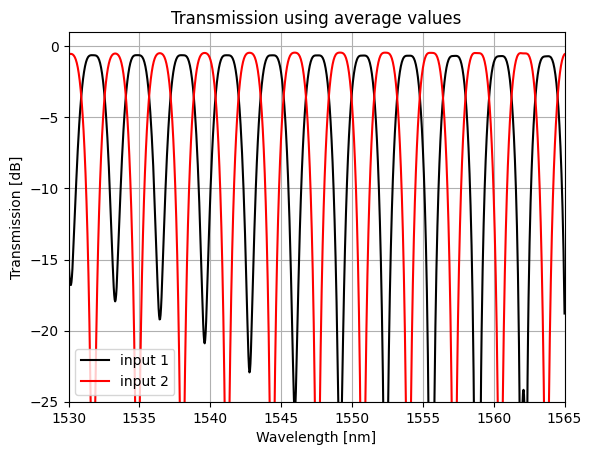

In [37]:
dataPDK = icApi.getresult('ona1', 'input 1/mode 1/gain')
data2PDK = icApi.getresult('ona1', 'input 2/mode 1/gain')
plt.plot(dataPDK['wavelength']/nm, dataPDK["'TE' gain (dB)"], color='black', label='input 1')
plt.plot(data2PDK['wavelength']/nm, data2PDK["'TE' gain (dB)"], color='red', label='input 2')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)
plt.grid()
plt.legend()
plt.title('Transmission using average values')

In [77]:
scriptName = 'Monte Carlo analysis'
icApi.deletesweep(scriptName)
icApi.addsweep(2)

'::Monte Carlo analysis'

In [78]:
trials = 50
scriptName = 'Monte Carlo analysis'
icApi.setsweep('Monte Carlo analysis','name', scriptName)
icApi.setsweep('Monte Carlo analysis', 'name', scriptName)
icApi.setsweep(scriptName, 'number of trials', trials)
icApi.setsweep(scriptName, 'batch size', trials)
icApi.setsweep(scriptName, 'enable seed', 1)
icApi.setsweep(scriptName, 'seed', 1)
icApi.setsweep(scriptName, 'Variation', 'Both')

1.0

In [79]:
icApi.switchtolayout()
icApi.refresh()
icApi.groupscope('3 st')
param = icApi.struct()
param['Name'] = f'wg1_width'
param['Parameter'] = f'::Root Element::3 st::wg1::wg_length'
param['Value'] = icApi.getnamed(f'wg1', 'wg_length')
dis = icApi.struct()
dis['type'] = 'gaussian'
dis['variation'] = icApi.getnamed('wg1', 'wg_length')*(0.1/100)
param['Distribution'] = dis
icApi.addsweepparameter(scriptName, param)

'wg1_width'

In [80]:
Tr = icApi.struct()
Tr['Name'] = "Transmission"
Tr['Result'] = f"::Root Element::ona1::input 1/mode 1/gain"
Tr['Estimation'] = False
icApi.addsweepresult(scriptName, Tr)

Tr2 = icApi.struct()
Tr2['Name'] = "FSR"
Tr2['Result'] = f"::Root Element::ona1::input 1/mode 1/peak/free spectral range"
Tr2['Estimation'] = False
icApi.addsweepresult(scriptName, Tr2)

'FSR'

In [81]:
icApi.save('mc_sweep')
icApi.runsweep(scriptName)

In [75]:
res = icApi.getsweepresult(scriptName, 'Transmission')
wl = res['wavelength'].flatten()

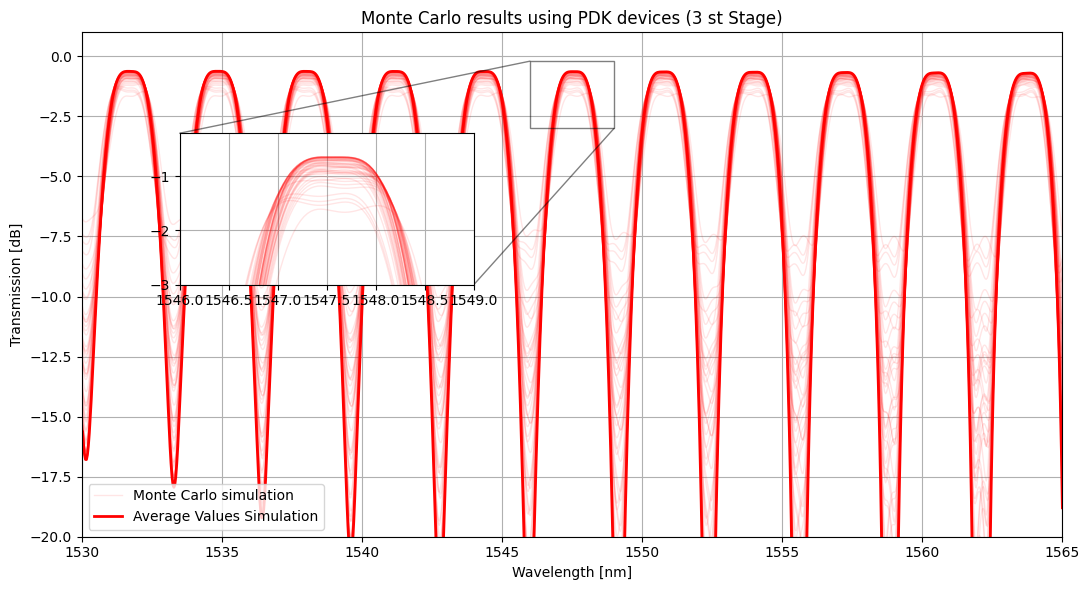

In [76]:
alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)
ax.plot(wl / nm, res["'TE' gain (dB)"][:,0], linewidth=1, color='red', label='Monte Carlo simulation',alpha=alfa)
ax.plot(wl / nm, res["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
ax.plot(dataPDK['wavelength']/nm, dataPDK["'TE' gain (dB)"], color='red', linewidth=2, label='Average Values Simulation')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.grid()
x1, x2, y1, y2 = 1546, 1549, -3, -0.2
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)

plt.grid(True)
plt.title('Monte Carlo results using PDK devices (3 st Stage)')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results PDK.png', dpi=300)

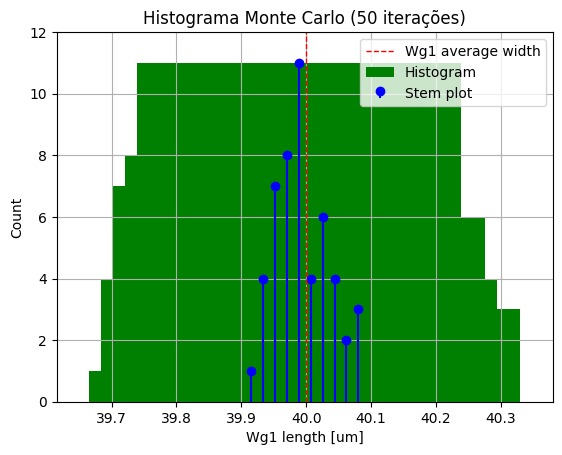

In [53]:
hist = icApi.getsweepresult(scriptName, 'analysis/parameters/histogram/wg1_width')
#hist
plt.bar(hist['wg1_width'].flatten()/um, hist['count'], label='Histogram', color='green', width=0.5)
plt.stem(hist['wg1_width'].flatten()/um, hist['count'], label='Stem plot', linefmt='b', markerfmt='bo', basefmt=' ')
plt.xlim(hist['wg1_width'][0][0][0]/um-0.3, hist['wg1_width'][-1][-1][-1]/um +0.3)
plt.ylim(0, 12)
plt.grid()
plt.vlines(40,0,18, color='red', linewidth=1, linestyles='--', label='Wg1 average width')
plt.xlabel('Wg1 length [um]')
plt.ylabel('Count')
plt.legend()
plt.title('Histograma Monte Carlo (50 iterações)')
plt.savefig('histograma wg1length.png')

In [54]:
icApi.deletesweep(scriptName)

## Adding all parameters

In [55]:
icApi.addsweep(2)

'::Monte Carlo analysis'

In [56]:
trials = 50
scriptName = 'Monte Carlo analysis'
icApi.setsweep('Monte Carlo analysis','name', scriptName)
icApi.setsweep('Monte Carlo analysis', 'name', scriptName)
icApi.setsweep(scriptName, 'number of trials', trials)
icApi.setsweep(scriptName, 'batch size', trials)
icApi.setsweep(scriptName, 'enable seed', 1)
icApi.setsweep(scriptName, 'seed', 1)
icApi.setsweep(scriptName, 'Variation', 'Both')

1.0

In [57]:
icApi.switchtolayout()
icApi.refresh()
icApi.groupscope('3 st')
##wg length
for i in range(4):
    param = icApi.struct()
    param['Name'] = f'wg{i+1}_length'
    param['Parameter'] = f'::Root Element::3 st::wg{i+1}::wg_length'
    param['Value'] = icApi.getnamed(f'wg{i+1}', 'wg_length')
    dis = icApi.struct()
    dis['type'] = 'gaussian'
    dis['variation'] = icApi.getnamed(f'wg{i+1}', 'wg_length')*(0.1/100)
    param['Distribution'] = dis
    icApi.addsweepparameter(scriptName, param)
## wg width
for i in range(4):
    param = icApi.struct()
    param['Name'] = f'wg{i+1}_width'
    param['Parameter'] = f'::Root Element::3 st::wg{i+1}::wg_width'
    param['Value'] = icApi.getnamed(f'wg{i+1}', 'wg_width')
    dis = icApi.struct()
    dis['type'] = 'gaussian'
    dis['variation'] = icApi.getnamed(f'wg{i+1}', 'wg_width')*(0.1/100)
    param['Distribution'] = dis
    icApi.addsweepparameter(scriptName, param)

## dcs coupling length
for i in range(3):
    param = icApi.struct()
    param['Name'] = f'dc{i+1}_coupling_length'
    param['Parameter'] = f'::Root Element::3 st::dc{i+1}::coupling_length'
    param['Value'] = icApi.getnamed(f'dc{i+1}', 'coupling_length')
    dis = icApi.struct()
    dis['type'] = 'gaussian'
    dis['variation'] = icApi.getnamed(f'dc{i+1}', 'coupling_length')*(0.1/100)
    param['Distribution'] = dis
    icApi.addsweepparameter(scriptName, param)

In [58]:
Tr = icApi.struct()
Tr['Name'] = "Transmission"
Tr['Result'] = f"::Root Element::ona1::input 1/mode 1/gain"
Tr['Estimation'] = True
icApi.addsweepresult(scriptName, Tr)

Tr1 = icApi.struct()
Tr1['Name'] = "Transmission1"
Tr1['Result'] = f"::Root Element::ona1::input 2/mode 1/gain"
Tr1['Estimation'] = True
icApi.addsweepresult(scriptName, Tr1)

'Transmission1'

In [59]:
icApi.save('mc_sweep_multipleParameters')
icApi.runsweep(scriptName)

In [60]:
res = icApi.getsweepresult(scriptName, 'Transmission')
wl = res['wavelength'].flatten()
res2 = icApi.getsweepresult(scriptName, 'Transmission1')

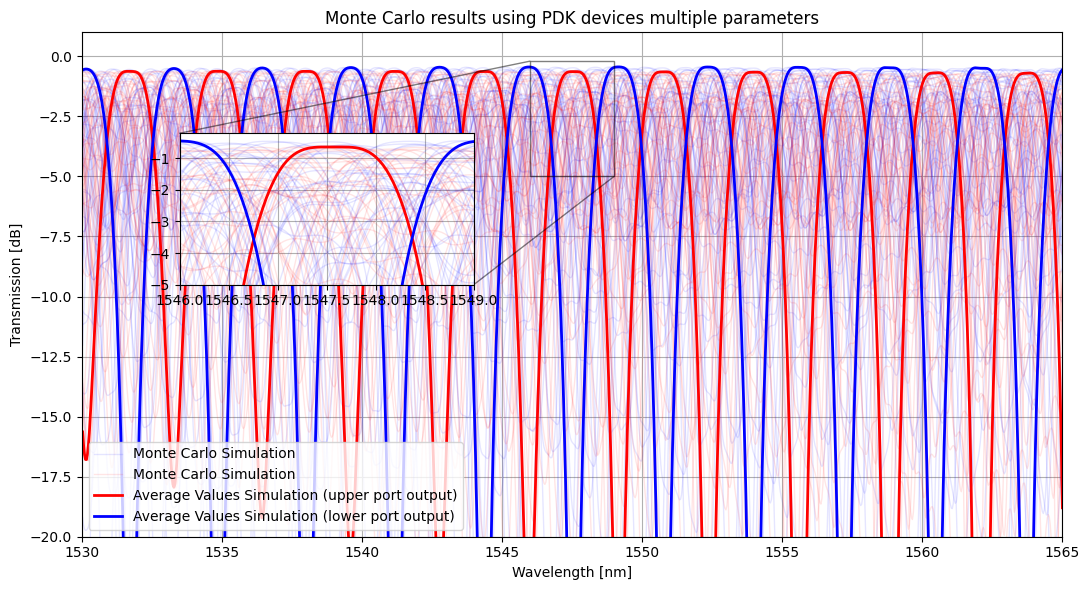

In [69]:
'''alfa = 0.1
plt.plot(wl / nm, res["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
plt.plot(wl / nm, res2["'TE' gain (dB)"], linewidth=1, color='blue', alpha=alfa)
plt.plot(dataPDK['wavelength']/nm, dataPDK["'TE' gain (dB)"], color='red', linewidth=2, label='Average Values Simulation Input 1 (ona)')
plt.plot(data2PDK['wavelength']/nm, data2PDK["'TE' gain (dB)"], color='blue', linewidth=2, label='Average Values Simulation Input 2 (ona)')
plt.xlim(1530, 1565)
plt.ylim(-20, 0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.legend()
plt.grid()
'''

alfa = 0.1
plt.figure(figsize=(11, 6))
ax = plt.subplot(111)

ax.plot(wl / nm, res2["'TE' gain (dB)"][:,0], linewidth=1, color='blue', alpha=alfa,label='Monte Carlo Simulation')
ax.plot(wl / nm, res["'TE' gain (dB)"][:,0], linewidth=1, color='red', alpha=alfa,label='Monte Carlo Simulation')

ax.plot(wl / nm, res2["'TE' gain (dB)"], linewidth=1, color='blue', alpha=alfa)
ax.plot(wl / nm, res["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
ax.plot(dataPDK['wavelength']/nm, dataPDK["'TE' gain (dB)"], color='red', linewidth=2, label='Average Values Simulation (upper port output)')
ax.plot(data2PDK['wavelength']/nm, data2PDK["'TE' gain (dB)"], color='blue', linewidth=2, label='Average Values Simulation (lower port output)')

zoom = ax.inset_axes([0.1, 0.5, 0.3, 0.3])
zoom.plot(wl / nm, res["'TE' gain (dB)"], linewidth=1, color='red', alpha=alfa)
zoom.plot(wl / nm, res2["'TE' gain (dB)"], linewidth=1, color='blue', alpha=alfa)
zoom.plot(dataPDK['wavelength']/nm, dataPDK["'TE' gain (dB)"], color='red', linewidth=2, label='Average Values Simulation')
zoom.plot(data2PDK['wavelength']/nm, data2PDK["'TE' gain (dB)"], color='blue', linewidth=2, label='Average Values Simulation Input 2 (ona)')
zoom.grid()

x1, x2, y1, y2 = 1546, 1549, -5, -0.2
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start / nm, wavelength_stop / nm)
plt.ylim(-20, 1)

plt.grid(True)
plt.title('Monte Carlo results using PDK devices multiple parameters')
plt.legend()
plt.tight_layout()
plt.savefig('Monte Carlo results PDK Multiple parameters.png', dpi=300)

## 200GHz (S-Parameters)

In [71]:
L = 40*um
FSR = 1.6*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)

In [72]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,8,1000,c/wavelength_start, c/wavelength_stop)
k = [0.5, 0.25,0.08]
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC,filenames, names[i], 3,3)

In [73]:
delayLengths_values[0]/um

array([ 218.56901847,  397.13803694, -316.82164336, -317.13803694])

In [74]:
def position2():
    icApi.setposition('3 st', 700, 100)
    icApi.setposition('2 st B', 900, -10)
    icApi.setposition('2 st A', 900, 200)
    icApi.setposition('1 st B', 1200, -60)
    icApi.setposition('1 st A', 1200, 40)
    icApi.setposition('1 st C', 1200, 150)
    icApi.setposition('1 st D', 1200, 250)
    return _
def connect2():    
    icApi.connect('3 st', 'port 2', 'ona1', 'output')
    
    icApi.connect('3 st', 'port 3', '2 st B', 'port 2')
    icApi.connect('3 st', 'port 4', '2 st A', 'port 1')
    
    icApi.connect('2 st B', 'port 3', '1 st B', 'port 2')
    icApi.connect('2 st B', 'port 4', '1 st A', 'port 1')
    
    icApi.connect('2 st A', 'port 3', '1 st C', 'port 2')
    icApi.connect('2 st A', 'port 4', '1 st D', 'port 1')
    
    #outputs to ona
    icApi.connect('1 st A', 'port 3', 'ona1', 'input 1')
    icApi.connect('1 st A', 'port 4', 'ona1', 'input 2')
    icApi.connect('1 st B', 'port 3', 'ona1', 'input 3')
    icApi.connect('1 st B', 'port 4', 'ona1', 'input 4')
    icApi.connect('1 st C', 'port 3', 'ona1', 'input 5')
    icApi.connect('1 st C', 'port 4', 'ona1', 'input 6')
    icApi.connect('1 st D', 'port 3', 'ona1', 'input 7')
    icApi.connect('1 st D', 'port 4', 'ona1', 'input 8')
    return _

In [75]:
position2()
connect2()
icApi.save('200GHz_circuit_SParameters')

In [76]:
icApi.run()

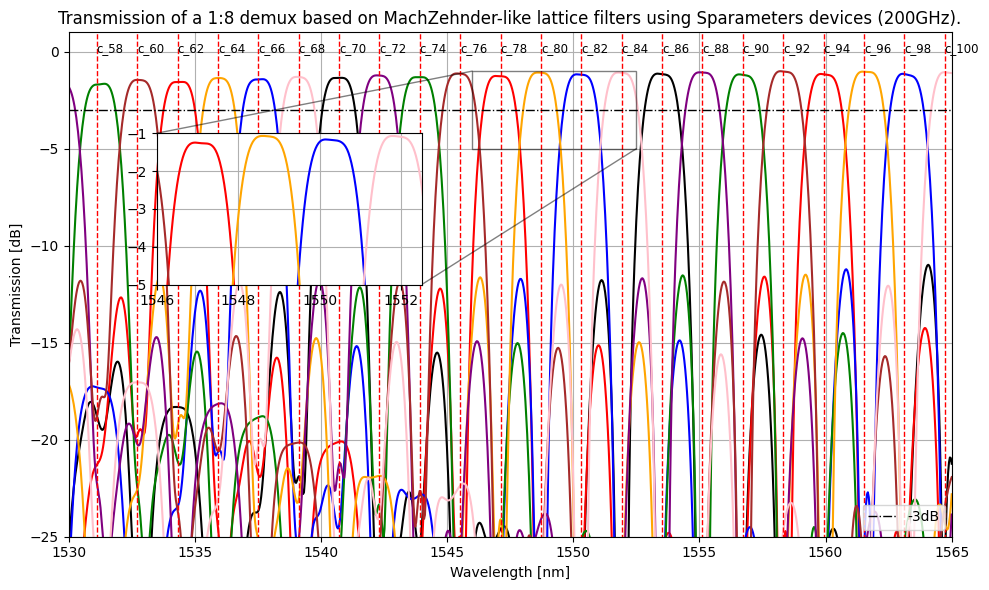

In [77]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["mode 1 gain (dB)"], color=colors[i])

for i in range(22):
    plt.vlines(1531.12+1.6*i, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--')
for i in range(22):
    plt.text(1531.12+1.6*i, 0, f'c_{58+2*i}', fontsize=8.5)
'''
plt.vlines(1546.95, ymin=-60, ymax=1, color='black', linewidth=1, linestyles='--', label='canal 26')
'''


zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    zoom.plot(data['wavelength']/nm, data["mode 1 gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1546, 1552.5, -5, -1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)
#plt.legend()
#plt.text(1549.2, -2, '1.6nm', fontsize=8.5)
plt.hlines(-3, xmin=1530, xmax=1565, color='black', linewidth=1, linestyles='-.', label='-3dB')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Transmission of a 1:8 demux based on MachZehnder-like lattice filters using Sparameters devices (200GHz).')
plt.tight_layout()
plt.savefig('TransmissionSparameters200GHz.png', dpi=300)

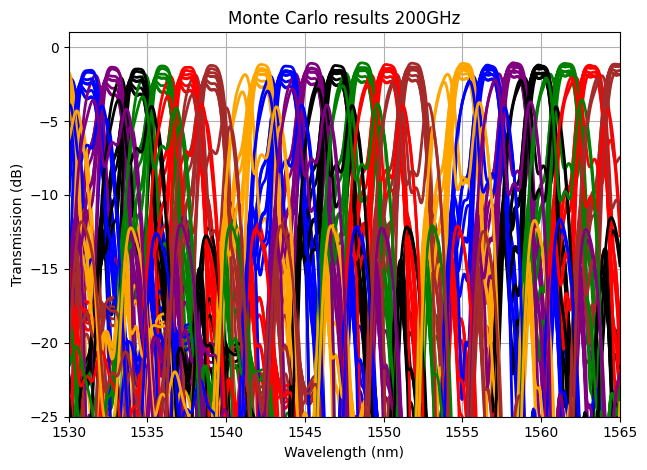

array([ 218.56901847,  397.13803694, -316.82164336, -317.13803694])

In [78]:
MonteCarlo('200GHz')

## 100GHz (SParameters)

In [79]:
L = 40*um
FSR = 0.8*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)

In [80]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
centralWl = 1547.5*nm
tools.placeOna(icApi,'ona1',1000,-200,8,1000,c/wavelength_start, c/wavelength_stop)
k = [0.5, 0.25,0.08]
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC,filenames, names[i], 3,3)

In [81]:
position2()
connect2()
icApi.save('100GHz_circuit_SParameters_WL=1550nm')

In [82]:
icApi.switchtolayout()
icApi.run()

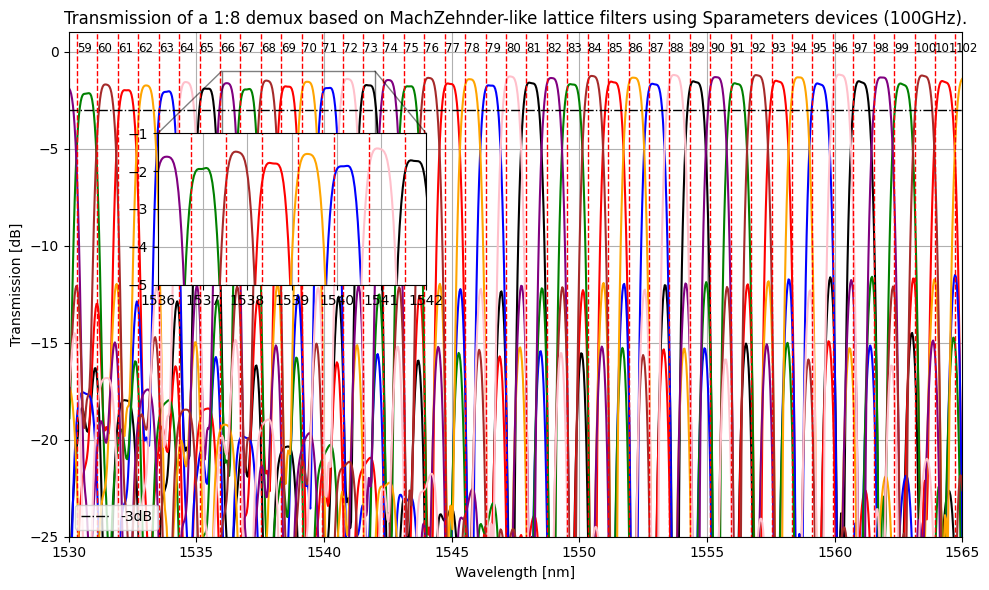

In [83]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["mode 1 gain (dB)"], color=colors[i])

zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    zoom.plot(data['wavelength']/nm, data["mode 1 gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1536, 1542, -5, -1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
for i in range(44):
    zoom.vlines(1530.33+0.8*i, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--')
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)


for i in range(44):
    plt.vlines(1530.33+0.8*i, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--')
for i in range(44):
    plt.text(1530.33+0.8*i, 0, f'{59+i}', fontsize=8.5)

plt.hlines(-3, xmin=1530, xmax=1565, color='black', linewidth=1, linestyles='-.', label='-3dB')
plt.legend(loc='lower left')
plt.grid(True)
plt.title('Transmission of a 1:8 demux based on MachZehnder-like lattice filters using Sparameters devices (100GHz).')
plt.tight_layout()
plt.savefig('TransmissionSparameters100GHz.png', dpi=300)

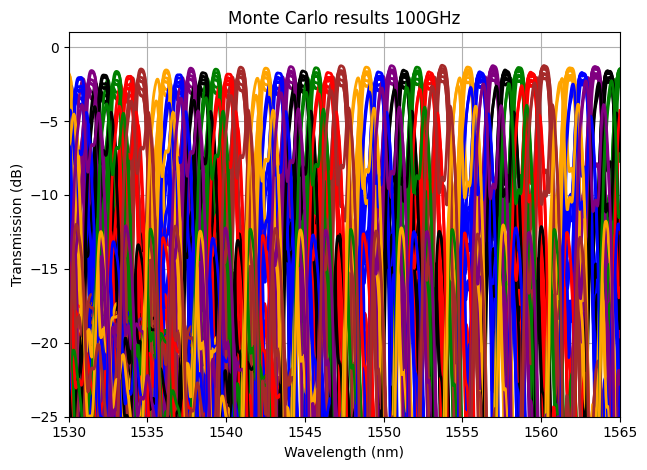

array([ 218.56901847,  397.13803694, -316.82164336, -317.13803694])

In [84]:
MonteCarlo('100GHz')

## 50GHz (SParameters

In [85]:
L = 40*um
FSR = 0.4*nm
delayLengths_values, names, LC, LC3rd, LC2nd, LC1st = calculateDelayLengths(L,FSR)

In [86]:
importlib.reload(tools)
icApi.switchtolayout()
icApi.deleteall()
tools.placeOna(icApi,'ona1',1000,-200,8,1000,c/wavelength_start, c/wavelength_stop)
k = [0.5, 0.25,0.08]
centralWl = 1547.5*nm
for i in range(7):
    tools.MZILatticefilter(icApi,neff,ng,L,delayLengths_values[i],k,LC,filenames, names[i], 3,3)

In [87]:
delayLengths_values[0][1]/um

np.float64(1468.552147758943)

In [88]:
position2()
connect2()
icApi.save('50GHz_circuit_SParameters')

In [89]:
icApi.run()

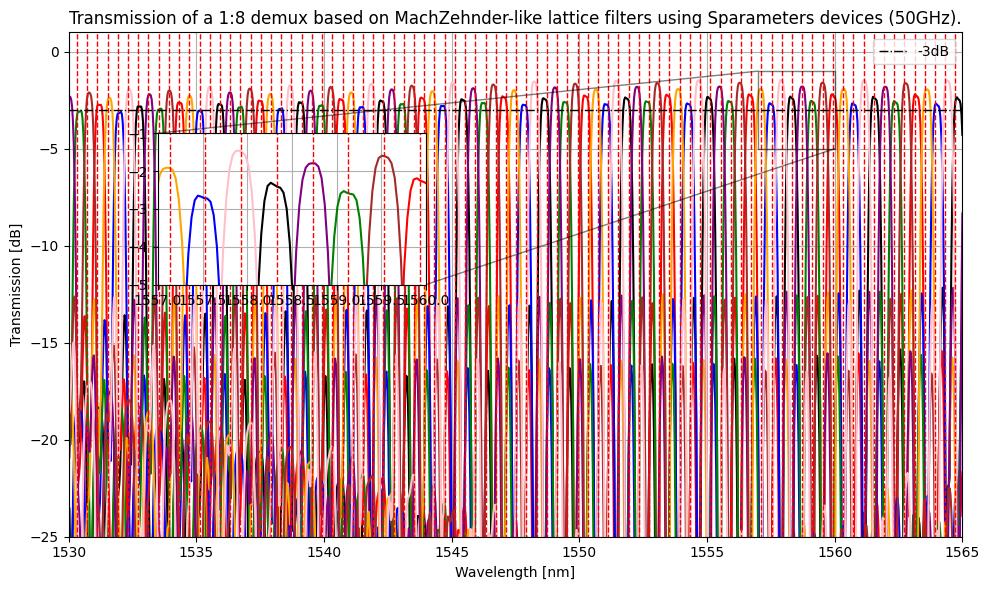

In [90]:
outputsOna = [
    'input 1/mode 1/gain',
    'input 2/mode 1/gain',
    'input 3/mode 1/gain',
    'input 4/mode 1/gain',
    'input 5/mode 1/gain',
    'input 6/mode 1/gain',
    'input 7/mode 1/gain',
    'input 8/mode 1/gain'
]

colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
labels = [rf'$\lambda${i+1}' for i in range(8)]


plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    ax.plot(data['wavelength']/nm, data["mode 1 gain (dB)"], color=colors[i])

for i in range(88):
    plt.vlines(1530.33+0.4*i, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--')
'''for i in range(44):
    plt.text(1530.72+0.8*i, 0, f'{59+i}', fontsize=8.5)'''

zoom = ax.inset_axes([0.1,0.5,0.3,0.3])
for i, path in enumerate(outputsOna):
    data = icApi.getresult('ona1', path)
    zoom.plot(data['wavelength']/nm, data["mode 1 gain (dB)"], color=colors[i])
zoom.grid()
x1, x2, y1, y2 = 1557, 1560, -5, -1
zoom.set_xlim(x1, x2)
zoom.set_ylim(y1, y2)
for i in range(88):
    zoom.vlines(1530.33+0.4*i, ymin=-60, ymax=1, color='red', linewidth=1, linestyles='--')
ax.indicate_inset_zoom(zoom, edgecolor="black", alpha=0.5)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.xlim(wavelength_start/nm, wavelength_stop/nm)
plt.ylim(-25, 1)
#plt.legend()
#plt.text(1549.2, -2, '1.6nm', fontsize=8.5)
plt.hlines(-3, xmin=1530, xmax=1565, color='black', linewidth=1, linestyles='-.', label='-3dB')
plt.legend()
plt.grid(True)
plt.title('Transmission of a 1:8 demux based on MachZehnder-like lattice filters using Sparameters devices (50GHz).')
plt.tight_layout()
plt.savefig('TransmissionSparameters50GHz.png', dpi=300)

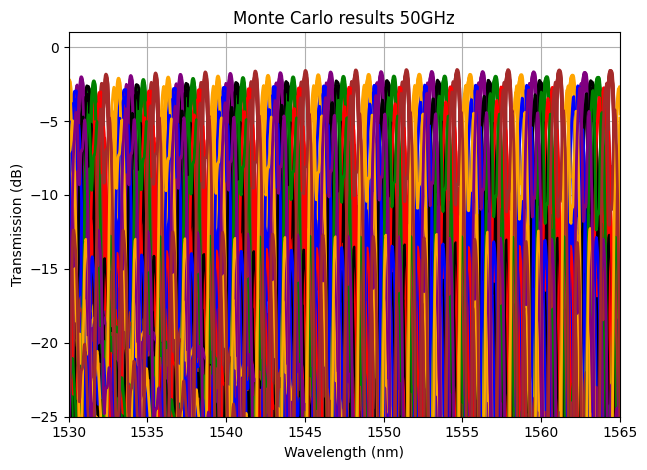

np.float64(1468.552147758943)

In [91]:
MonteCarlo('50GHz')